<H1> Разработка инструмента для прогнозирования популярности постов в социальных сетях с применением методов машинного обучения </H1>

Проект содержит следующие этапы:
* Сбор БД и визуализация данных
* Токенизация, лемматизация и стемминг данных
* **Векторизация**
* Классификация
* Подбор гиперпараметров и демонстрация итоговых результатов

Для корректной работы кода необходимо загрузить файл "ITMO_2.csv", полученный в рамках предыдущего шага проекта.

# **Векторизация**
Векторизация текста — это процесс преобразования текста в числовой формат, который могут понимать и обрабатывать алгоритмы машинного обучения

## Bag of Words
Мешок слов — представление текста в виде массива, состоящего из отдельных слов и количества их использования

In [ ]:
import csv
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer

In [ ]:
import csv
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer

def vectorize_text_bag_of_words(input_file, output_file, num_records=15540):
    # векторизация текста через Bag of Words

    # пустой список для записи в него текстов
    corpus = []

    # чтение столбца lemmatized_text
    with open(input_file, 'r', encoding='utf-8') as file:
        reader = csv.DictReader(file)
        # запись в пустой список
        for i, row in enumerate(reader):
            if i >= num_records:
                break
            lemmatized_text = row['lemmatized_text']
            corpus.append(lemmatized_text)

    # непосредственно векторизация через мешок слов
    vectorizer = CountVectorizer()
    X = vectorizer.fit_transform(corpus)
    feature_names = vectorizer.get_feature_names_out()

    # Сохранение данных в формате npz
    np.savez_compressed(output_file, X=X.toarray(), feature_names=feature_names)

# вызов функции
vectorize_text_bag_of_words('ITMO_2.csv', 'ITMO_2_vectorized_bag_of_words.npz', num_records=15627)

## TF-IDF
TF-IDF - это статистическая мера, используемая для оценки важности слова в контексте документа

In [ ]:
import csv
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer

def vectorize_text_tf_idf(input_file, output_file):
    # векторизация текста через TF-IDF

    # пустой список для записи в него текстов
    corpus = []

    # чтение столбца lemmatized_text
    with open(input_file, 'r', encoding='utf-8') as file:
        reader = csv.DictReader(file)
        # запись в пустой список
        for row in reader:
            lemmatized_text = row['lemmatized_text']
            corpus.append(lemmatized_text)

    # непосредственно векторизация через мешок слов
    vectorizer = TfidfVectorizer()
    X = vectorizer.fit_transform(corpus)
    feature_names = vectorizer.get_feature_names_out()

    # Сохранение данных в формате npz
    np.savez_compressed(output_file, X=X.toarray(), feature_names=feature_names)

# вызов функции
vectorize_text_tf_idf('ITMO_2.csv', 'ITMO_2_vectorized_tf_idf.npz')

## Word2Vec
Word2Vec - модель, которая позволяет получать численные векторные представления слов, которые отражают семантические и синтаксические связи между ними

In [ ]:
import csv
import gensim.downloader as api
import numpy as np
from gensim.matutils import full2sparse_clipped

def vectorize_text_word2vec(input_file, output_file):
    # загрузка предобученной модели
    wv = api.load('word2vec-ruscorpora-300')
    vocab = wv.index_to_key  # используем словарь из модели Word2Vec

    # пустой список для записи в него текстов
    corpus = []
    corpus_vectors = []

    # чтение столбца lemmatized_text
    with open(input_file, 'r', encoding='utf-8') as file:
        reader = csv.DictReader(file)
        # запись в пустой список
        for row in reader:
            lemmatized_text = row['lemmatized_text']
            corpus.append(lemmatized_text)

            # вектора каждого слова из предложения
            preprocessing_text = lemmatized_text.split()
            vectors_word = [wv[word] if word in vocab else np.zeros(300) for word in preprocessing_text]
            vector_text = np.mean(full2sparse_clipped(vectors_word, 300), axis=0)
            corpus_vectors.append(vector_text)

    # сохранение в формате .npz
    np.savez_compressed(output_file, corpus=np.array(corpus, dtype=object), corpus_vectors=np.array(corpus_vectors))

# вызов функции
vectorize_text_word2vec('ITMO_2.csv', 'ITMO_2_vectorized_word2vec.npz')

[==================================================] 100.0% 198.8/198.8MB downloaded


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


# **Определение тональности текста**
Анализ тональности текста (англ. Sentiment analysis) — задача компьютерной лингвистики, заключающаяся в определении эмоциональной окраски (тональности) текста и, в частности, в выявлении эмоциональной оценки авторов по отношению к объектам, описываемым в тексте.

In [ ]:
!pip install pymorphy2 > None
import pymorphy2

In [ ]:
import pandas as pd
import urllib.request
import re

# загрузка данных из файла
data = pd.read_csv('ITMO_2.csv')

# скачивание словаря RuSentiLex
url = 'http://www.labinform.ru/pub/rusentilex/rusentilex_2017.txt'
urllib.request.urlretrieve(url, 'rusentilex_2017.txt')

# работа со словарем RuSentiLex
senti_lexicon = {}
with open('rusentilex_2017.txt', 'r', encoding='utf-8') as f:
    for line in f:
        # пропуск строк, которые начинаются с !
        if not line.startswith('!'):
            parts = line.strip().split(',')
            # преобразуем оставшиеся строки в пары ключ-значение
            if len(parts) >= 4:
                word = parts[0]
                sentiment = parts[3]
                senti_lexicon[word] = sentiment


def get_text_sentiment(lemmatized_text):
    # определение тональности

    # разбиваю каждую строку на отдельные слова
    tokens = re.split(r'\s+', lemmatized_text)
    # счетчики в ноль
    positive_count = 0
    negative_count = 0
    neutral_count = 0

    # каждому слову в строке начисляю "баллы" за positive, negative, neutral
    for token in tokens:
        if token in senti_lexicon:
            sentiment = senti_lexicon[token]
            if sentiment == 'pos':
                positive_count += 1
            elif sentiment == 'neg':
                negative_count += 1
            else:
                neutral_count += 1

    # подсчитываю кол-во баллов по каждой тональности
    max_count = max(positive_count, negative_count, neutral_count)
    # если в строке больше позитивных слов, но вся строка позитивная
    if max_count == positive_count:
        return 'Positive'
    # если в строке больше негативных слов, то вся строка негативная
    elif max_count == negative_count:
        return 'Negative'
    # в остальных случаях строка нейтральная
    else:
        return 'Neutral'

# применение функции к столбцу с лемматизированными текстами
data['sentiment'] = data['lemmatized_text'].fillna('').apply(get_text_sentiment)

# Сохранение результатов в новый файл
data.to_csv('ITMO_3.csv', index=False)

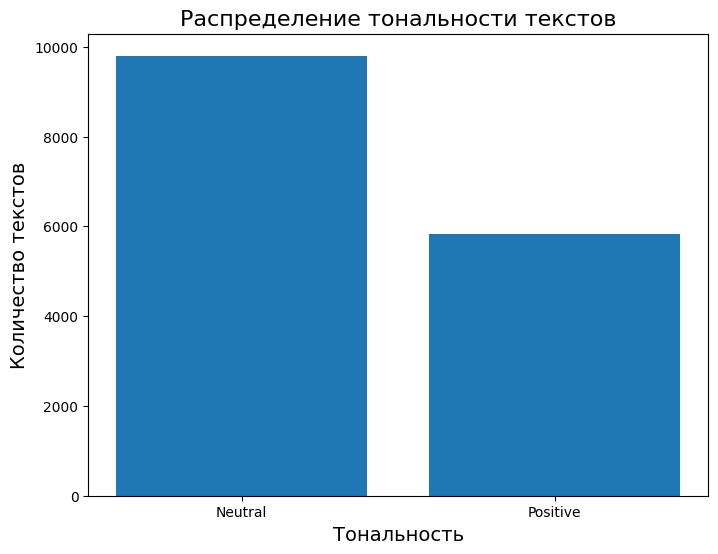

In [ ]:
import matplotlib.pyplot as plt

# подсчет количества текстов для каждой тональности
sentiment_counts = data['sentiment'].value_counts()

# создание графика
fig, ax = plt.subplots(figsize=(8, 6))
ax.bar(sentiment_counts.index, sentiment_counts.values)
ax.set_title('Распределение тональности текстов', fontsize=16)
ax.set_xlabel('Тональность', fontsize=14)
ax.set_ylabel('Количество текстов', fontsize=14)

# вывод графика
plt.show()

В рамках работы с датасетом было выполнено несколько преобразований. Каждый из них сохранен под определенным порядковым номером:
<li> ITMO_0.csv - исходный датасет в результате парсинга стены vk
<li> ITMO_1.csv - датасет с добавлением столбца популярности поста (если набрал > 30 лайков)
<li> ITMO_2.csv - датасет с токенизацией, лемматизацией и стеммингом
<li> ITMO_2_vectorized_bag_of_words.npz - векторизация через Bag of Words
<li> ITMO_2_vectorized_tf_idf.npz - векторизация через TF-IDF
<li> ITMO_2_vectorized_word2vec.npz.csv - векторизация через Word2Vec
<li> ITMO_3.csv - датасет с добавлением столбца по анализу сентимента (позитив, негатив, нейтралитет)

**Промежуточные выводы:**
<li> Была выполнена векторизация текста тремя подходами: Bag of Words, TF-IDF, Word2Vec
<li> Решена задача определения тональности текста. На официальной странице университета в VK размещается только нейтральная или позитивная информация